In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
!unzip "/content/gdrive/MyDrive/CUS615_Team6_Project/Data.zip" -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/Data/Tumor/pituitary_tumor/P_217_HF_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_217_RO_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_217_SP_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_217_VF_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218_BR_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218_DA_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218_HF_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218_RO_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218_SP_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_218_VF_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_219.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_219_BR_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_219_DA_.jpg  
  inflating: data/Data/Tumor/pituitary_tumor/P_219_HF_.jpg  
  inflating: data/Data/Tumor/pituitary_tum

In [ ]:
!rm -rf "/content/data/__MACOSX"

In [ ]:
normal_path = '/content/data/Data/Normal'
tumor_path = '/content/data/Data/Tumor'
image_extensions = ['.png', '.jpg', '.jpeg']

In [ ]:
normal_files = glob.glob(os.path.join(normal_path, '**', '*.*'), recursive=True)
normal_files = [f for f in normal_files if os.path.splitext(f)[1].lower() in image_extensions]
normal_labels = [0] * len(normal_files)

In [ ]:
tumor_files = []
for folder in os.listdir(tumor_path):
    folder_path = os.path.join(tumor_path, folder)
    if os.path.isdir(folder_path):
        files = glob.glob(os.path.join(folder_path, '*.*'))
        files = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]
        tumor_files.extend(files)
tumor_labels = [1] * len(tumor_files)

In [ ]:
df = pd.DataFrame({
    'filepath': normal_files + tumor_files,
    'label': normal_labels + tumor_labels
})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])

In [ ]:
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Training samples: 13002
Validation samples: 4335
Test samples: 4335


Data Augmentation and Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (100, 100)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

Found 13002 validated image filenames belonging to 2 classes.
Found 4335 validated image filenames belonging to 2 classes.
Found 4335 validated image filenames belonging to 2 classes.


CNN Classifier: Training, Evaluation & Visualization

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
history = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

test_loss, test_acc = cnn_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 355s 863ms/step - accuracy: 0.8588 - loss: 0.3994 - val_accuracy: 0.8238 - val_loss: 0.4217
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 357s 877ms/step - accuracy: 0.8713 - loss: 0.3125 - val_accuracy: 0.8055 - val_loss: 0.4586
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 342s 840ms/step - accuracy: 0.8878 - loss: 0.2694 - val_accuracy: 0.8987 - val_loss: 0.2265
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 342s 840ms/step - accuracy: 0.8965 - loss: 0.2368 - val_accuracy: 0.8265 - val_loss: 0.4093
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 409s 908ms/step - accuracy: 0.9076 - loss: 0.2130 - val_accuracy: 0.8881 - val_loss: 0.3327
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 342s 841ms/step - accuracy: 0.9161 - loss: 0.1929 - val_accuracy: 0.8955 - val_loss: 0.2843
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 338s 830ms/step - accuracy: 0.9213 - loss: 0.1845 - val_accuracy: 0.9170 - val_loss: 0.2103
Epoch 8/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 336s 824ms/step - accuracy: 0.9207 -

Additional Metrics: Precision, Recall, F1-score, ROC AUC & Confusion Matrix

136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step
              precision    recall  f1-score   support

      Normal       0.67      0.88      0.76       613
       Tumor       0.98      0.93      0.95      3722

    accuracy                           0.92      4335
   macro avg       0.82      0.91      0.86      4335
weighted avg       0.94      0.92      0.93      4335

ROC AUC Score: 0.9674699967478761


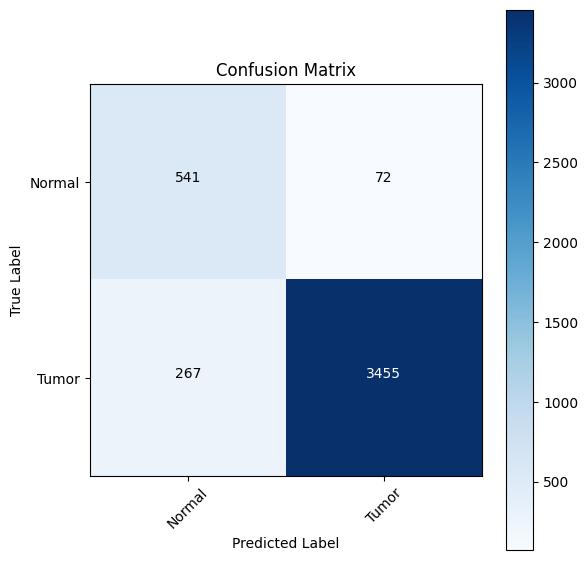

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

test_generator.reset()
y_pred_prob = cnn_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=['Normal', 'Tumor']))

roc_auc = roc_auc_score(y_true, y_pred_prob)
print("ROC AUC Score:", roc_auc)


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Normal', 'Tumor'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Tumor'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Visualization of Results

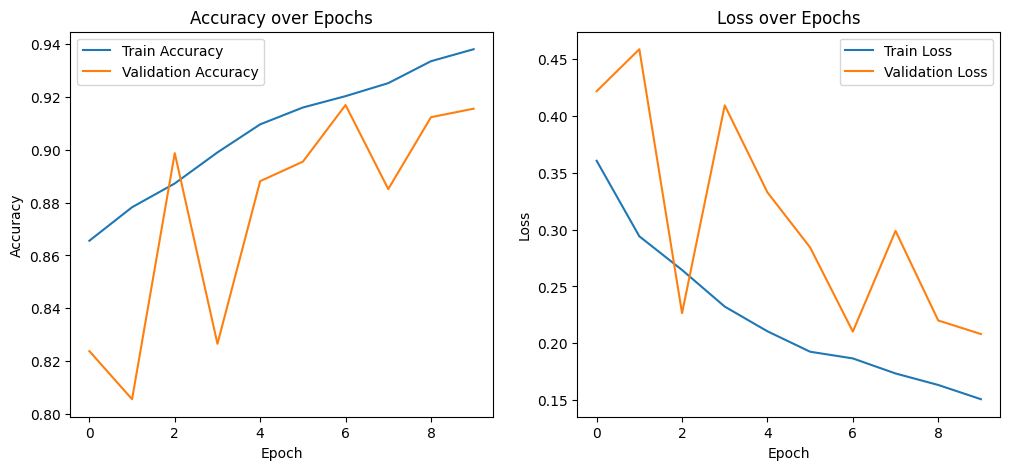

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

In [ ]:
test_generator.reset()
predictions = cnn_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes

cm = confusion_matrix(true_labels, predicted_labels)

136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 222ms/step


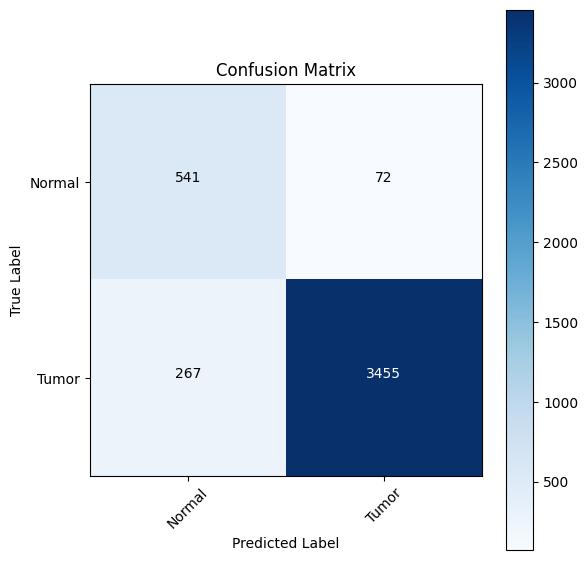

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Normal', 'Tumor'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Tumor'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


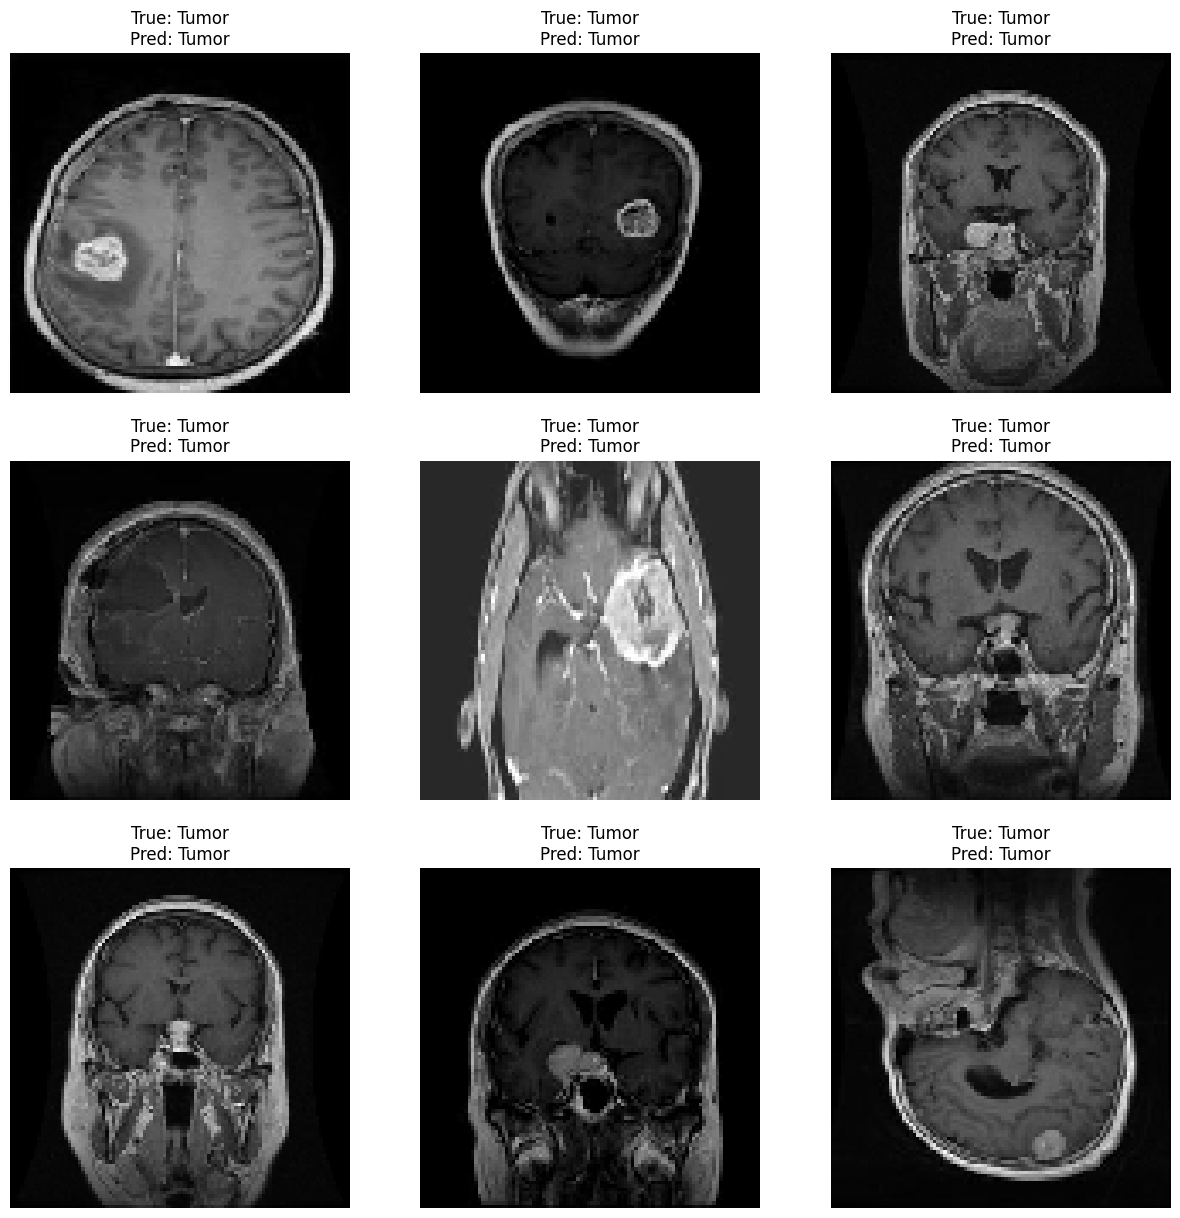

In [ ]:
test_generator.reset()
test_images, test_labels = next(test_generator)
preds = cnn_model.predict(test_images)
preds = (preds > 0.5).astype(int).flatten()

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    true_class = 'Tumor' if test_labels[i] == 1.0 else 'Normal'
    pred_class = 'Tumor' if preds[i] == 1 else 'Normal'
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis('off')
plt.show()

Traditional Machine Learning Models: Decision Tree & SVM

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
def load_and_preprocess(filepath, target_size=(100, 100)):
    img = cv2.imread(filepath)
    if img is None:
        return np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def extract_features(file_list, target_size=(100, 100)):
    features = []
    for fp in tqdm(file_list, desc="Extracting features"):
        img = load_and_preprocess(fp, target_size)
        features.append(img.flatten())
    return np.array(features)

In [ ]:
train_df_ml = train_df.copy()
val_df_ml = val_df.copy()
test_df_ml = test_df.copy()
train_df_ml['label'] = train_df_ml['label'].astype(int)
val_df_ml['label'] = val_df_ml['label'].astype(int)
test_df_ml['label'] = test_df_ml['label'].astype(int)

In [ ]:
X_train = extract_features(train_df_ml['filepath'].tolist())
y_train = train_df_ml['label'].values

X_val = extract_features(val_df_ml['filepath'].tolist())
y_val = val_df_ml['label'].values

X_test = extract_features(test_df_ml['filepath'].tolist())
y_test = test_df_ml['label'].values

Extracting features: 100%|██████████| 4335/4335 [00:02<00:00, 1797.46it/s]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=200, random_state=42)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_val_reduced = pca.transform(X_val_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_clf.fit(X_train_reduced, y_train)
dt_val_pred = dt_clf.predict(X_val_reduced)
print("Decision Tree Validation Accuracy:", accuracy_score(y_val, dt_val_pred))
dt_test_pred = dt_clf.predict(X_test_reduced)
print("Decision Tree Test Accuracy:", accuracy_score(y_test, dt_test_pred))

Decision Tree Validation Accuracy: 0.9121107266435986
Decision Tree Test Accuracy: 0.9155709342560554


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_test_pred, target_names=['Normal', 'Tumor']))

dt_precision = precision_score(y_test, dt_test_pred)
dt_recall = recall_score(y_test, dt_test_pred)
dt_f1 = f1_score(y_test, dt_test_pred)
print("Decision Tree Precision:", dt_precision)
print("Decision Tree Recall:", dt_recall)
print("Decision Tree F1 Score:", dt_f1)

dt_probs = dt_clf.predict_proba(X_test_reduced)[:, 1]
dt_roc_auc = roc_auc_score(y_test, dt_probs)
print("Decision Tree ROC AUC Score:", dt_roc_auc)


Decision Tree Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.64      0.68       613
       Tumor       0.94      0.96      0.95      3722

    accuracy                           0.92      4335
   macro avg       0.83      0.80      0.82      4335
weighted avg       0.91      0.92      0.91      4335

Decision Tree Precision: 0.9425105485232067
Decision Tree Recall: 0.9602364320257926
Decision Tree F1 Score: 0.9512909236092627
Decision Tree ROC AUC Score: 0.7747292891874336


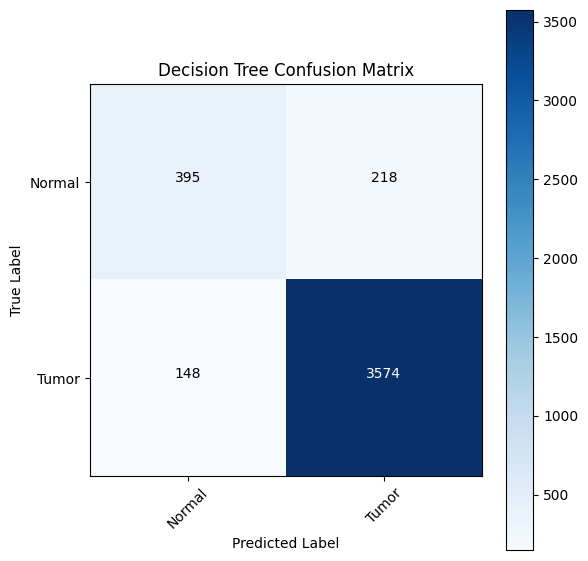

In [ ]:
cm_dt = confusion_matrix(y_test, dt_test_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Normal', 'Tumor'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Tumor'])
thresh = cm_dt.max() / 2.
for i, j in itertools.product(range(cm_dt.shape[0]), range(cm_dt.shape[1])):
    plt.text(j, i, format(cm_dt[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_dt[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
svm_clf = LinearSVC(random_state=42, max_iter=10000)
svm_clf.fit(X_train_reduced, y_train)
svm_val_pred = svm_clf.predict(X_val_reduced)
print("Linear SVM Validation Accuracy:", accuracy_score(y_val, svm_val_pred))
svm_test_pred = svm_clf.predict(X_test_reduced)
print("Linear SVM Test Accuracy:", accuracy_score(y_test, svm_test_pred))

Linear SVM Validation Accuracy: 0.8747404844290657
Linear SVM Test Accuracy: 0.8777393310265282


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

print("\nLinear SVM Classification Report:")
print(classification_report(y_test, svm_test_pred, target_names=['Normal', 'Tumor']))

svm_precision = precision_score(y_test, svm_test_pred)
svm_recall = recall_score(y_test, svm_test_pred)
svm_f1 = f1_score(y_test, svm_test_pred)
print("Linear SVM Precision:", svm_precision)
print("Linear SVM Recall:", svm_recall)
print("Linear SVM F1 Score:", svm_f1)

svm_scores = svm_clf.decision_function(X_test_reduced)
svm_roc_auc = roc_auc_score(y_test, svm_scores)
print("Linear SVM ROC AUC Score:", svm_roc_auc)


Linear SVM Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.27      0.39       613
       Tumor       0.89      0.98      0.93      3722

    accuracy                           0.88      4335
   macro avg       0.78      0.63      0.66      4335
weighted avg       0.86      0.88      0.86      4335

Linear SVM Precision: 0.8909848113669769
Linear SVM Recall: 0.977162815690489
Linear SVM F1 Score: 0.9320861096873398
Linear SVM ROC AUC Score: 0.8443639643651389


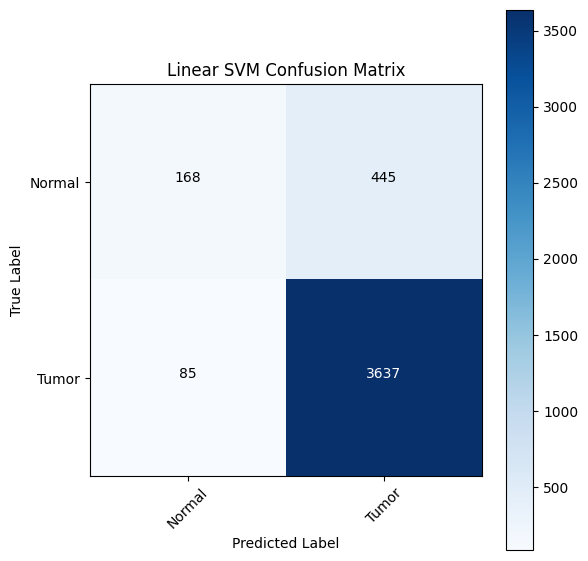

In [ ]:
cm_svm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Linear SVM Confusion Matrix")
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Normal', 'Tumor'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Tumor'])
thresh = cm_svm.max() / 2.
for i, j in itertools.product(range(cm_svm.shape[0]), range(cm_svm.shape[1])):
    plt.text(j, i, format(cm_svm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_svm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()